In [3]:
!pip install nltk

Movie Sentimental Analysis


Source:-https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews



IMDB dataset having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms. For more dataset information, please go through the following link, http://ai.stanford.edu/~amaas/data/sentiment/

Objective:- Given a review, determine whether the review is positive or negative


Attributes:-

1.Review-Text

2.Sentiment-Positive or Negative

In [84]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
nltk.download('stopwords')
from nltk.corpus import stopwords

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
df=pd.read_csv("IMDB Dataset.csv")

In [86]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


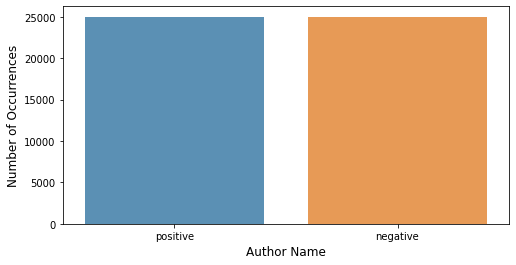

In [87]:
cnt_srs = df['sentiment'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [88]:
import re

def decontracted(phrase):
    
    phrase = re.sub(r"won't", "will not", phrase)   
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [89]:
def removehtml(sent):
    cleanr = re.compile('<.*?>')
    cleartext = re.sub(cleanr, ' ', sent)
    return cleartext

In [90]:
from tqdm import tqdm
filtered_review=[]

for sent in tqdm(df['review'].values):
  sent=decontracted(sent)
  sent=removehtml(sent)
  sent=sent.replace("\'", "")
  
  sent=' '.join(i for i in sent.split())
  filtered_review.append(sent.strip())

100%|██████████| 50000/50000 [00:02<00:00, 18354.13it/s]


In [91]:
df['review']=filtered_review

In [92]:
df.drop_duplicates(subset={'review'},keep="first",inplace=True)

In [93]:
df.shape

(49578, 2)

In [94]:
train_df=df[:34704]
test_df=df[34704:]

In [95]:
test_df.shape

(14874, 2)

Feature Engineering



1.   Meta features - Features that are extracted from the text like number of   words, number of stop words, number of punctuations etc

2.   Text based features - Features directly based on the text / words like frequency, svd, word2vec etc.



In [96]:
## Number of words in the text ##
train_df["num_words"] = train_df["review"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["review"].apply(lambda x: len(str(x).split()))

## Number of unique words in the review ##
train_df["num_unique_words"] = train_df["review"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["review"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the review ##
train_df["num_chars"] = train_df["review"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["review"].apply(lambda x: len(str(x)))

## Number of stopwords in the review ##
train_df["num_stopwords"] = train_df["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the review ##
train_df["num_punctuations"] =train_df['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the review ##
train_df["num_words_upper"] = train_df["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the review ##
train_df["num_words_title"] = train_df["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the review ##
train_df["mean_word_len"] = train_df["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [97]:
s = {'positive':0, 'negative':1}
train_y = train_df['sentiment'].map(s)

cols_to_drop = ['review']
train_X = train_df.drop(cols_to_drop+['sentiment'], axis=1)
test_X = test_df.drop(cols_to_drop+['sentiment'], axis=1)

In [98]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 2
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [99]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([df.shape[0], 2])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.iloc[dev_index], train_X.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:0.692371	test-mlogloss:0.692569
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.681124	test-mlogloss:0.683993
[40]	train-mlogloss:0.675747	test-mlogloss:0.680607
[60]	train-mlogloss:0.671061	test-mlogloss:0.677641
[80]	train-mlogloss:0.666515	test-mlogloss:0.674707
[100]	train-mlogloss:0.663915	test-mlogloss:0.673491
[120]	train-mlogloss:0.66049	test-mlogloss:0.671604
[140]	train-mlogloss:0.65856	test-mlogloss:0.670935
[160]	train-mlogloss:0.65659	test-mlogloss:0.670061
[180]	train-mlogloss:0.654462	test-mlogloss:0.66923
[200]	train-mlogloss:0.652741	test-mlogloss:0.668618
[220]	train-mlogloss:0.651121	test-mlogloss:0.668382
[240]	train-mlogloss:0.649528	test-mlogloss:0.668188
[260]	train-mlogloss:0.64811	test-mlogloss:0.667912
[280]	train-mlogloss:0.646826	test-mlogloss:0.667606
[300]	train-mlogloss:0.645518	test-mlogloss:0.667324
[320]	train-

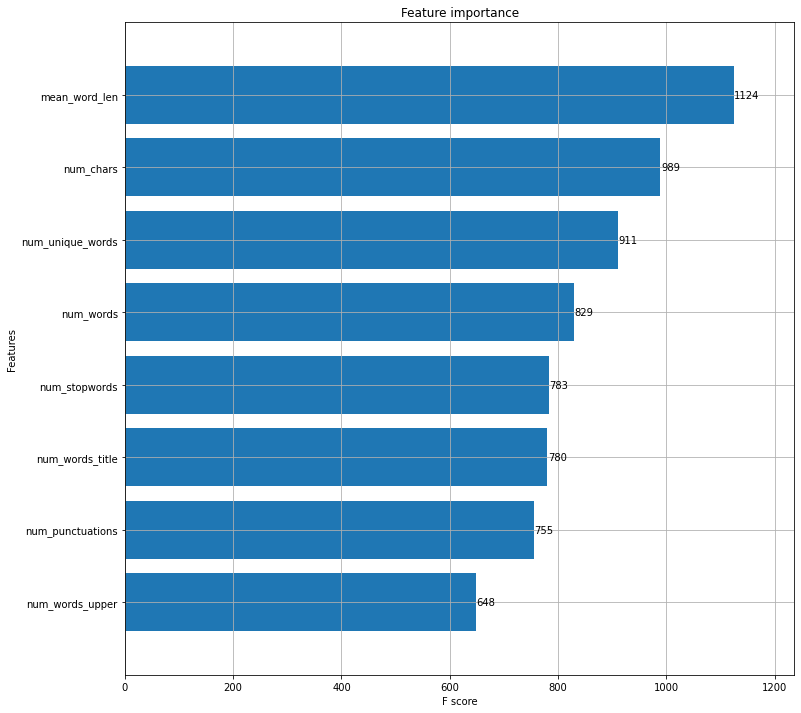

In [100]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Text Based Features :



In [101]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['review'].values.tolist() + test_df['review'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['review'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['review'].values.tolist())

In [102]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [103]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.49516468120129253


In [104]:
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

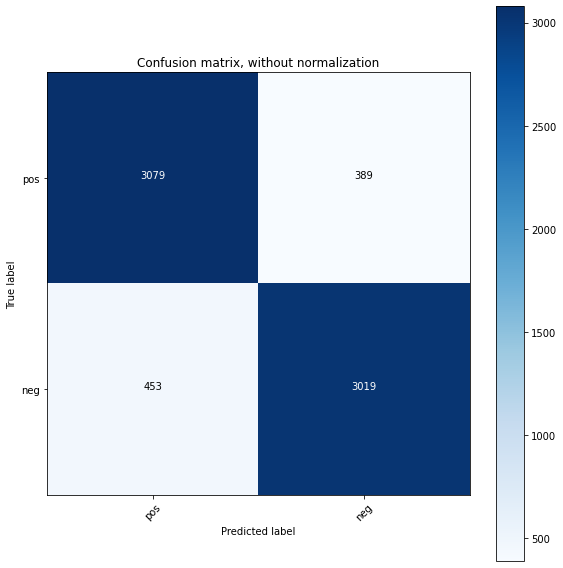

In [105]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['pos', 'neg'],
                      title='Confusion matrix, without normalization')
plt.show()

In [106]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [107]:
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['review'].values.astype('U').tolist() + test_df['review'].values.astype('U').tolist())
train_tfidf = tfidf_vec.transform(train_df['review'].values.astype('U').tolist())
test_tfidf = tfidf_vec.transform(test_df['review'].values.astype('U').tolist())

In [108]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_pos"] = pred_train[:,0]
train_df["nb_cvec_neg"] = pred_train[:,1]
test_df["nb_cvec_pos"] = pred_full_test[:,0]
test_df["nb_cvec_neg"] = pred_full_test[:,1]

Mean cv score :  1.8550624995080605


In [109]:
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['review'].values.astype('U').tolist() + test_df['review'].values.astype('U').tolist())
train_tfidf = tfidf_vec.transform(train_df['review'].values.astype('U').tolist())
test_tfidf = tfidf_vec.transform(test_df['review'].values.astype('U').tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_pos"] = pred_train[:,0]
train_df["nb_cvec_char_neg"] = pred_train[:,1]

test_df["nb_cvec_char_pos"] = pred_full_test[:,0]
test_df["nb_cvec_char_neg"] = pred_full_test[:,1]

Mean cv score :  12.690168187170567


In [110]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['review'].values.astype('U').tolist() + test_df['review'].values.astype('U').tolist())
train_tfidf = tfidf_vec.transform(train_df['review'].values.astype('U').tolist())
test_tfidf = tfidf_vec.transform(test_df['review'].values.astype('U').tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_pos"] = pred_train[:,0]
train_df["nb_tfidf_char_neg"] = pred_train[:,1]
test_df["nb_tfidf_char_pos"] = pred_full_test[:,0]
test_df["nb_tfidf_char_neg"] = pred_full_test[:,1]


Mean cv score :  0.6933971200810449


As we can see here our Text Based features have performed well as compared to the Meta Features.


Ideas for further improvement 


*   Parameter Tuning for tfidf vectorizer.
*   Parameter Tuning for naive bayes and XGB Models.

